## İmport libary and Dataset load

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity 
import pyspark
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.tuning import ParamGridBuilder , CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import dill as pickle
from joblib import dump, load


import psycopg2
from urllib.parse import urlparse

import findspark
findspark.init()
#İgnore Error
import warnings
warnings.simplefilter(action="ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [4, 4]
#plt.figure(figsize =(5, 3))


In [2]:
books = pd.read_csv('books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [3]:
print(users.shape)
print(books.shape)
print(ratings.shape)

(278858, 3)
(271360, 8)
(1149780, 3)


In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271359 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [5]:
books.imageUrlL.head()

0    http://images.amazon.com/images/P/0195153448.0...
1    http://images.amazon.com/images/P/0002005018.0...
2    http://images.amazon.com/images/P/0060973129.0...
3    http://images.amazon.com/images/P/0374157065.0...
4    http://images.amazon.com/images/P/0393045218.0...
Name: imageUrlL, dtype: object

In [6]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


## Exploration Data Analiysis

#### Books Dataset check

In [7]:
#BOOK VALUE CHECK
total = books.isnull().sum().sort_values(ascending=False)
percent_1 = books.isnull().sum()/books.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(12)


,Total,%
imageUrlL,3,0.0
publisher,2,0.0
bookAuthor,1,0.0
ISBN,0,0.0
bookTitle,0,0.0
yearOfPublication,0,0.0
imageUrlS,0,0.0
imageUrlM,0,0.0


In [8]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [9]:
#update wrong value 
#ISBN 0789466953
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [10]:
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [11]:
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [12]:
#Other anomaly value
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [13]:
#Update ISBN 2070426769
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [14]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce') #Convert int

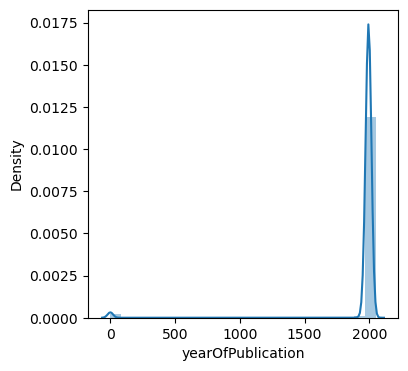

In [15]:
sns.distplot(books['yearOfPublication'],kde=True,bins=25);
plt.savefig('Year Publisher.png')

In [16]:
books.yearOfPublication.describe()#Minimum year value 0

count    271360.000000
mean       1959.761273
std         257.992836
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: yearOfPublication, dtype: float64

In [17]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN#We learned that the dataset was prepared until 2006

In [18]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)#use mean values

In [19]:
books.yearOfPublication.describe()

count    271360.000000
mean       1993.692493
std           8.248976
min        1376.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2006.000000
Name: yearOfPublication, dtype: float64

In [20]:
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [21]:
#saw 2 null values above
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [22]:
#change the other publisher
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

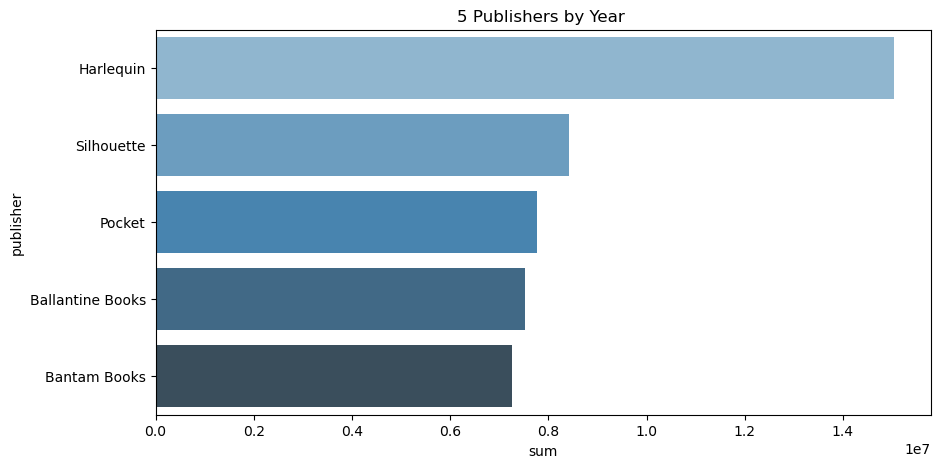

In [23]:
plt.figure(figsize=(10, 5))
plt.title("5 Publishers by Year ")
publisher = books.groupby(['publisher']).yearOfPublication.agg(['sum']).reset_index()
publisher =publisher.nlargest(5,'sum')
sns.barplot(x="sum", y="publisher", orient = "h", data=publisher, palette = "Blues_d")
plt.savefig('Top5publisher.png')

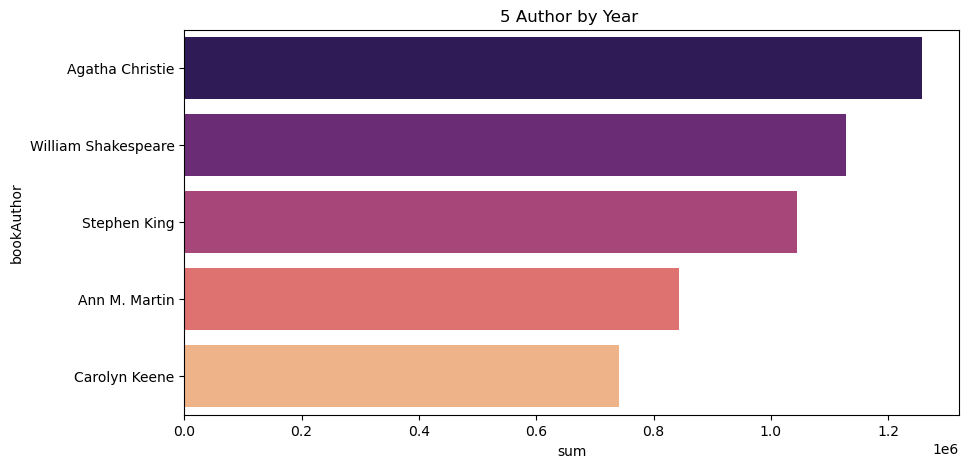

In [28]:
plt.figure(figsize=(10, 5))
plt.title("5 Author by Year ")
bookAuthor = books.groupby(['bookAuthor']).yearOfPublication.agg(['sum']).reset_index()
publisher = bookAuthor.nlargest(5,'sum')
sns.barplot(x="sum", y="bookAuthor", orient = "h", data=publisher, palette = "magma")
plt.savefig('Top5author.png')

In [23]:
#USER VALUE CHECK
total = users.isnull().sum().sort_values(ascending=False)
percent_1 = users.isnull().sum()/users.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(12)

,Total,%
Age,110762,39.7
userID,0,0.0
Location,0,0.0


In [24]:
users.Age.describe()#Age anormaly

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [25]:
users.loc[(users.Age > 90) | (users.Age < 10), 'Age'] = np.nan#min 10 , maximum 90 years

In [26]:
users.Age=users.Age.fillna(users.Age.mean())

In [27]:
users.Age.describe()

count    278858.000000
mean         34.754311
std          10.483135
min          10.000000
25%          29.000000
50%          34.754311
75%          35.000000
max          90.000000
Name: Age, dtype: float64

In [28]:
users.Age = users.Age.astype(np.int32)

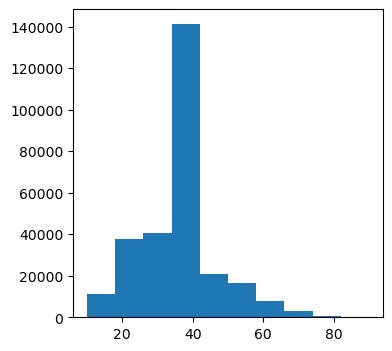

In [29]:
plt.hist(x=users.Age);
plt.savefig('Agehist.png')

In [30]:
#Rating Data set valu check
total = ratings.isnull().sum().sort_values(ascending=False)
percent_1 = ratings.isnull().sum()/ratings.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(12)

,Total,%
userID,0,0.0
ISBN,0,0.0
bookRating,0,0.0


In [31]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


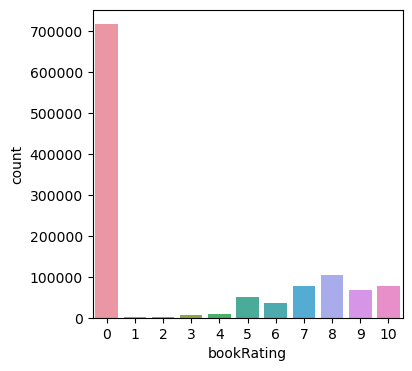

In [32]:
sns.countplot(x=ratings['bookRating']);#i want to see Rating the distribution

In [33]:
#if i wanted to get the ones with equal rating isbn numbers with the books
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [34]:
print(ratings.shape)
print(ratings_new.shape)

(1149780, 3)
(1031136, 3)


In [35]:
#our goal is to get user ratings
ratings = ratings[ratings.userID.isin(users.userID)]

In [36]:
#Since i will create a recommendation system, we cannot recommend a book with 0 ratings.
explicitdf = ratings_new[ratings_new.bookRating != 0]
implicitdf = ratings_new[ratings_new.bookRating == 0]

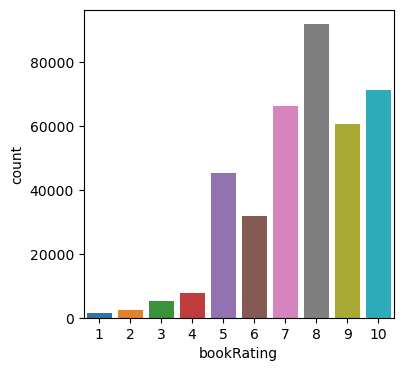

In [37]:
sns.countplot(x=explicitdf['bookRating']);

In [38]:
explicitdf['bookRating'].value_counts(normalize=True)

8     0.239171
10    0.185558
7     0.172993
9     0.158341
5     0.118161
6     0.082552
4     0.019844
3     0.013334
2     0.006187
1     0.003858
Name: bookRating, dtype: float64

In [39]:
explicitdf

,userID,ISBN,bookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9
...,...,...,...
1149771,276704,0743211383,7
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10


## Item Based recommendation

In [40]:
#Top 10 best rated books 
popular_products = pd.DataFrame(explicitdf.groupby('ISBN')['bookRating'].count())
most_popular = popular_products.sort_values('bookRating', ascending=False).head(10)
top10=most_popular.merge(books,left_index = True, right_on = 'ISBN')
top10

,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
408,707,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
26,581,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
748,487,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
522,383,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
1105,320,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
2143,313,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...
356,307,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...
706,295,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
305,281,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...
231,278,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...


In [41]:
top10.to_pickle("top10.pkl")  

## Content based

In [42]:
#bought 1200 books against and  memory errors because there is a recommendation system.
products = pd.DataFrame(explicitdf.groupby('ISBN')['bookRating'].count())
popular = products.sort_values('bookRating', ascending=False).head(1200)
most=popular.merge(books,left_index = True, right_on = 'ISBN')

In [43]:
most.bookTitle.nunique()

1089

In [44]:
n = 1200
top_n=most.bookTitle.value_counts().index[:n]
books_df=most[most['bookTitle'].isin(top_n)]

In [45]:
books_df.shape

(1200, 9)

In [46]:
#Since I will use similarity rates in the content recommendation system, I gathered all the features together.
books_df['text']=books_df['bookTitle']+' '+books_df['bookAuthor']+' '+books_df['publisher']

In [47]:
books_df['text']

408      The Lovely Bones: A Novel Alice Sebold Little,...
26                        Wild Animus Rich Shapero Too Far
748                  The Da Vinci Code Dan Brown Doubleday
522      The Red Tent (Bestselling Backlist) Anita Diam...
1105     Divine Secrets of the Ya-Ya Sisterhood: A Nove...
                               ...                        
9460                        Bitter Harvest Ann Rule Pocket
586              The Straw Men Michael Marshall Jove Books
3729       The Midnight Club James Patterson Warner Vision
10428    Cold Fire Dean R. Koontz Berkley Publishing Group
8782      84 Charing Cross Road Helene Hanff Penguin Books
Name: text, Length: 1200, dtype: object

In [48]:
#I removed the books to avoid recommending the same books.
books_df.drop_duplicates(subset=['text'], inplace=True)
books_df.drop_duplicates(subset=['bookTitle'], inplace=True)
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 408 to 8782
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   bookRating         1089 non-null   int64 
 1   ISBN               1089 non-null   object
 2   bookTitle          1089 non-null   object
 3   bookAuthor         1089 non-null   object
 4   yearOfPublication  1089 non-null   int32 
 5   publisher          1089 non-null   object
 6   imageUrlS          1089 non-null   object
 7   imageUrlM          1089 non-null   object
 8   imageUrlL          1089 non-null   object
 9   text               1089 non-null   object
dtypes: int32(1), int64(1), object(8)
memory usage: 89.3+ KB


In [49]:
books_df.dropna(subset='bookTitle', inplace=True)
books_df.reset_index(drop=True, inplace=True)
books_df

,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,text
0,707,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,"The Lovely Bones: A Novel Alice Sebold Little,..."
1,581,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus Rich Shapero Too Far
2,487,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,The Da Vinci Code Dan Brown Doubleday
3,383,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,The Red Tent (Bestselling Backlist) Anita Diam...
4,320,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,Divine Secrets of the Ya-Ya Sisterhood: A Nove...
...,...,...,...,...,...,...,...,...,...,...
1084,29,0671868691,Bitter Harvest,Ann Rule,1999,Pocket,http://images.amazon.com/images/P/0671868691.0...,http://images.amazon.com/images/P/0671868691.0...,http://images.amazon.com/images/P/0671868691.0...,Bitter Harvest Ann Rule Pocket
1085,29,0515134279,The Straw Men,Michael Marshall,2002,Jove Books,http://images.amazon.com/images/P/0515134279.0...,http://images.amazon.com/images/P/0515134279.0...,http://images.amazon.com/images/P/0515134279.0...,The Straw Men Michael Marshall Jove Books
1086,29,0446606383,The Midnight Club,James Patterson,1999,Warner Vision,http://images.amazon.com/images/P/0446606383.0...,http://images.amazon.com/images/P/0446606383.0...,http://images.amazon.com/images/P/0446606383.0...,The Midnight Club James Patterson Warner Vision
1087,28,0425130711,Cold Fire,Dean R. Koontz,1996,Berkley Publishing Group,http://images.amazon.com/images/P/0425130711.0...,http://images.amazon.com/images/P/0425130711.0...,http://images.amazon.com/images/P/0425130711.0...,Cold Fire Dean R. Koontz Berkley Publishing Group


In [50]:
#I vectorized the book and features to use similarity criteria.
tfidf = TfidfVectorizer(stop_words='english') # 
books_df['text'] = books_df['text'].fillna('')

tfidf_matrix = tfidf.fit_transform(books_df['text'])
tfidf_matrix.shape

(1089, 2444)

In [51]:
#Cosine similarity rates
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.10111174, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10111174, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [52]:
#Create Books İndex
indices = pd.Series(books_df.index, index=books_df['bookTitle'])
indices

bookTitle
The Lovely Bones: A Novel                             0
Wild Animus                                           1
The Da Vinci Code                                     2
The Red Tent (Bestselling Backlist)                   3
Divine Secrets of the Ya-Ya Sisterhood: A Novel       4
                                                   ... 
Bitter Harvest                                     1084
The Straw Men                                      1085
The Midnight Club                                  1086
Cold Fire                                          1087
84 Charing Cross Road                              1088
Length: 1089, dtype: int64

In [53]:
#for Recommendation function
def get_recommendations(book, cosine_sim=cosine_sim):
    
    idx = indices[book] # Her bir biraya karşılık gelen index değerleri

    sim_scores = list(enumerate(cosine_sim[idx])) # Biralar arasındaki ikili benzerlik puanları

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # Benzerlik oranlarına göre sıralama

    sim_scores = sim_scores[1:11] # En benzer 10 bira

    book_indices = [i[0] for i in sim_scores] # Bu biraların index değerleri

    return books_df['bookTitle'].iloc[book_indices] # En benzer 10 birayı göster

In [54]:
get_recommendations('The Lovely Bones: A Novel')

570             The Lovely Bones
710                        Lucky
81              Lucky : A Memoir
776                 Nine Stories
585       BAG OF BONES : A NOVEL
95      White Oleander : A Novel
623                   The Jester
424    The Big Bad Wolf: A Novel
569               The Lake House
545          The Weight of Water
Name: bookTitle, dtype: object

In [55]:
get_recommendations('Wild Animus')

87                                         Into the Wild
594    Rich Dad, Poor Dad: What the Rich Teach Their ...
410                                     Call of the Wild
956                                 Succulent Wild Woman
0                              The Lovely Bones: A Novel
2                                      The Da Vinci Code
3                    The Red Tent (Bestselling Backlist)
4        Divine Secrets of the Ya-Ya Sisterhood: A Novel
5      Harry Potter and the Sorcerer's Stone (Harry P...
6                                The Secret Life of Bees
Name: bookTitle, dtype: object

In [56]:
get_recommendations('Airframe')

31                  Timeline
75                    Sphere
139                    Congo
224               Disclosure
145           The Lost World
189               Rising Sun
1009        The Terminal Man
575       Eaters of the Dead
29             Jurassic Park
266     The Andromeda Strain
Name: bookTitle, dtype: object

In [94]:
#content=pickle.dumps()
dump(get_recommendations, 'content.pkl')

['content.pkl']

## Collabarity conttent

In [57]:
books_df

,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,text
0,707,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,"The Lovely Bones: A Novel Alice Sebold Little,..."
1,581,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus Rich Shapero Too Far
2,487,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,The Da Vinci Code Dan Brown Doubleday
3,383,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,The Red Tent (Bestselling Backlist) Anita Diam...
4,320,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,Divine Secrets of the Ya-Ya Sisterhood: A Nove...
...,...,...,...,...,...,...,...,...,...,...
1084,29,0671868691,Bitter Harvest,Ann Rule,1999,Pocket,http://images.amazon.com/images/P/0671868691.0...,http://images.amazon.com/images/P/0671868691.0...,http://images.amazon.com/images/P/0671868691.0...,Bitter Harvest Ann Rule Pocket
1085,29,0515134279,The Straw Men,Michael Marshall,2002,Jove Books,http://images.amazon.com/images/P/0515134279.0...,http://images.amazon.com/images/P/0515134279.0...,http://images.amazon.com/images/P/0515134279.0...,The Straw Men Michael Marshall Jove Books
1086,29,0446606383,The Midnight Club,James Patterson,1999,Warner Vision,http://images.amazon.com/images/P/0446606383.0...,http://images.amazon.com/images/P/0446606383.0...,http://images.amazon.com/images/P/0446606383.0...,The Midnight Club James Patterson Warner Vision
1087,28,0425130711,Cold Fire,Dean R. Koontz,1996,Berkley Publishing Group,http://images.amazon.com/images/P/0425130711.0...,http://images.amazon.com/images/P/0425130711.0...,http://images.amazon.com/images/P/0425130711.0...,Cold Fire Dean R. Koontz Berkley Publishing Group


In [58]:
collabarity = books.set_index('ISBN').join(ratings.set_index('ISBN'))

In [59]:
collabarity

,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,userID,bookRating
ISBN,,,,,,,,,
0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,171118.0,8.0
0001010565,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,86123.0,0.0
0001010565,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,209516.0,0.0
0001046438,Liar,Stephen Fry,1994,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,23902.0,9.0
0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,196149.0,0.0
...,...,...,...,...,...,...,...,...,...
B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,264317.0,0.0
B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,100906.0,0.0
B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,1994,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,100088.0,0.0


In [60]:
collabarity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1032345 entries, 0000913154 to B0002K6K8O
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   bookTitle          1032345 non-null  object 
 1   bookAuthor         1032344 non-null  object 
 2   yearOfPublication  1032345 non-null  int32  
 3   publisher          1032345 non-null  object 
 4   imageUrlS          1032345 non-null  object 
 5   imageUrlM          1032345 non-null  object 
 6   imageUrlL          1032341 non-null  object 
 7   userID             1031136 non-null  float64
 8   bookRating         1031136 non-null  float64
dtypes: float64(2), int32(1), object(6)
memory usage: 74.8+ MB


In [61]:
n = 1200
columns=['imageUrlS','imageUrlM','imageUrlL','yearOfPublication']
collabarity.drop(columns=columns,inplace=True)
top_m = collabarity.bookTitle.value_counts().index[:n] # En çok değerlendirilen 250 bira

collabarity = collabarity[collabarity['bookTitle'].isin(top_n)]
collabarity.head()

,bookTitle,bookAuthor,publisher,userID,bookRating
ISBN,,,,,
0001047973,Brave New World,Aldous Huxley,Trafalgar Square Publishing,11944.0,9.0
0001047973,Brave New World,Aldous Huxley,Trafalgar Square Publishing,23902.0,9.0
0001382608,On the Road,Huck Scarry,HarperCollins Publishers,26583.0,0.0
0002558122,Angelas Ashes,Frank Mccourt,Harpercollins Australia,278474.0,0.0
0002558122,Angelas Ashes,Frank Mccourt,Harpercollins Australia,11676.0,8.0


In [62]:
df_wide = pd.pivot_table(collabarity, values=['bookRating'],
        index=['bookTitle', 'userID'],
        aggfunc=np.mean).unstack() # Tablonun görünümünü düzenlemek için küçük bir düzeltme
df_wide.shape

(1089, 39854)

In [63]:
df_wide

bookRating           \
userID                                               8.0      9.0        
bookTitle                                                                
1984                                                      NaN      NaN   
1st to Die: A Novel                                       NaN      NaN   
2010: Odyssey Two                                         NaN      NaN   
2nd Chance                                                NaN      NaN   
3rd Degree                                                NaN      NaN   
...                                                       ...      ...   
Writ of Execution                                         NaN      NaN   
Year of Wonders                                           NaN      NaN   
You Belong To Me                                          NaN      NaN   
Zen and the Art of Motorcycle Maintenance: An I...        NaN      NaN   
\O\" Is for Outlaw"                                       NaN      NaN   

                                                                               \
userID                                             14.0     16.0     17.0       
bookTitle                                                                       
1984                                                    NaN      NaN      NaN   
1st to Die: A Novel                                     NaN      NaN      NaN   
2010: Odyssey Two                                       NaN      NaN      NaN   
2nd Chance                                              NaN      NaN      NaN   
3rd Degree                                              NaN      NaN      NaN   
...                                                     ...      ...      ...   
Writ of Execution                                       NaN      NaN      NaN   
Year of Wonders                                         NaN      NaN      NaN   
You Belong To Me                                        NaN      NaN      NaN   
Zen and the Art of Motorcycle Maintenance: An I...      NaN      NaN      NaN   
\O\" Is for Outlaw"                                     NaN      NaN      NaN   

                                                                               \
userID                                             26.0     32.0     39.0       
bookTitle                                                                       
1984                                                    NaN      NaN      NaN   
1st to Die: A Novel                                     NaN      NaN      NaN   
2010: Odyssey Two                                       NaN      NaN      NaN   
2nd Chance                                              NaN      NaN      NaN   
3rd Degree                                              NaN      NaN      NaN   
...                                                     ...      ...      ...   
Writ of Execution                                       NaN      NaN      NaN   
Year of Wonders                                         NaN      NaN      NaN   
You Belong To Me                                        NaN      NaN      NaN   
Zen and the Art of Motorcycle Maintenance: An I...      NaN      NaN      NaN   
\O\" Is for Outlaw"                                     NaN      NaN      NaN   

                                                                      ...  \
userID                                             42.0     44.0      ...   
bookTitle                                                             ...   
1984                                                    NaN      NaN  ...   
1st to Die: A Novel                                     NaN      NaN  ...   
2010: Odyssey Two                                       NaN      NaN  ...   
2nd Chance                                              NaN      NaN  ...   
3rd Degree                                              NaN      NaN  ...   
...                                                     ...      ...  ...   
Writ of Execution                                  

In [64]:
df_wide = df_wide.fillna(0)
df_wide

bookRating           \
userID                                               8.0      9.0        
bookTitle                                                                
1984                                                      0.0      0.0   
1st to Die: A Novel                                       0.0      0.0   
2010: Odyssey Two                                         0.0      0.0   
2nd Chance                                                0.0      0.0   
3rd Degree                                                0.0      0.0   
...                                                       ...      ...   
Writ of Execution                                         0.0      0.0   
Year of Wonders                                           0.0      0.0   
You Belong To Me                                          0.0      0.0   
Zen and the Art of Motorcycle Maintenance: An I...        0.0      0.0   
\O\" Is for Outlaw"                                       0.0      0.0   

                                                                               \
userID                                             14.0     16.0     17.0       
bookTitle                                                                       
1984                                                    0.0      0.0      0.0   
1st to Die: A Novel                                     0.0      0.0      0.0   
2010: Odyssey Two                                       0.0      0.0      0.0   
2nd Chance                                              0.0      0.0      0.0   
3rd Degree                                              0.0      0.0      0.0   
...                                                     ...      ...      ...   
Writ of Execution                                       0.0      0.0      0.0   
Year of Wonders                                         0.0      0.0      0.0   
You Belong To Me                                        0.0      0.0      0.0   
Zen and the Art of Motorcycle Maintenance: An I...      0.0      0.0      0.0   
\O\" Is for Outlaw"                                     0.0      0.0      0.0   

                                                                               \
userID                                             26.0     32.0     39.0       
bookTitle                                                                       
1984                                                    0.0      0.0      0.0   
1st to Die: A Novel                                     0.0      0.0      0.0   
2010: Odyssey Two                                       0.0      0.0      0.0   
2nd Chance                                              0.0      0.0      0.0   
3rd Degree                                              0.0      0.0      0.0   
...                                                     ...      ...      ...   
Writ of Execution                                       0.0      0.0      0.0   
Year of Wonders                                         0.0      0.0      0.0   
You Belong To Me                                        0.0      0.0      0.0   
Zen and the Art of Motorcycle Maintenance: An I...      0.0      0.0      0.0   
\O\" Is for Outlaw"                                     0.0      0.0      0.0   

                                                                      ...  \
userID                                             42.0     44.0      ...   
bookTitle                                                             ...   
1984                                                    0.0      0.0  ...   
1st to Die: A Novel                                     0.0      0.0  ...   
2010: Odyssey Two                                       0.0      0.0  ...   
2nd Chance                                              0.0      0.0  ...   
3rd Degree                                              0.0      0.0  ...   
...                                                     ...      ...  ...   
Writ of Execution                                  

In [65]:
cosine_sim2 = cosine_similarity(df_wide)
cosine_sim2

array([[1.        , 0.01854548, 0.04640847, ..., 0.00369797, 0.03288815,
        0.00912194],
       [0.01854548, 1.        , 0.0077612 , ..., 0.05506564, 0.01386289,
        0.05358723],
       [0.04640847, 0.0077612 , 1.        , ..., 0.        , 0.03163616,
        0.        ],
       ...,
       [0.00369797, 0.05506564, 0.        , ..., 1.        , 0.01122291,
        0.04992586],
       [0.03288815, 0.01386289, 0.03163616, ..., 0.01122291, 1.        ,
        0.00426846],
       [0.00912194, 0.05358723, 0.        , ..., 0.04992586, 0.00426846,
        1.        ]])

In [66]:
cosine_sim2_df = pd.DataFrame(cosine_sim2, index=df_wide.index, columns=df_wide.index)
cosine_sim2_df.head()

bookTitle,1984,1st to Die: A Novel,2010: Odyssey Two,2nd Chance,3rd Degree,4 Blondes,84 Charing Cross Road,A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,A Case of Need,...,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)","Wizard's First Rule (Sword of Truth, Book 1)","Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Writ of Execution,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,"\O\"" Is for Outlaw"""
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,1.000000,0.018545,0.046408,0.002475,0.002337,0.0000,0.026168,0.013894,0.008516,0.032173,...,0.011049,0.001837,0.040445,0.000000,0.068412,0.003084,0.022879,0.003698,0.032888,0.009122
1st to Die: A Novel,0.018545,1.000000,0.007761,0.154149,0.070527,0.0000,0.009118,0.000000,0.032029,0.027480,...,0.053582,0.031012,0.025053,0.014949,0.023475,0.035994,0.015796,0.055066,0.013863,0.053587
2010: Odyssey Two,0.046408,0.007761,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.022363,...,0.000000,0.024073,0.026774,0.023393,0.021792,0.000000,0.014614,0.000000,0.031636,0.000000
2nd Chance,0.002475,0.154149,0.000000,1.000000,0.145252,0.0109,0.009410,0.000000,0.041766,0.047677,...,0.044576,0.004536,0.049643,0.023236,0.011087,0.085710,0.016919,0.041607,0.009514,0.027426
3rd Degree,0.002337,0.070527,0.000000,0.145252,1.000000,0.0000,0.008885,0.000000,0.020478,0.010231,...,0.024434,0.004283,0.024115,0.030100,0.010468,0.043154,0.000000,0.008624,0.007092,0.003280


In [95]:
def find_similar_films(films, count=1):
    """
    Parameters
    ----------
    beers: list
        some beer names!
        
    count: int (default=1)
        count of similar beer!
    
    Returns
    -------
    ranked_beers: list
        rank ordered beers
    """
    films = [films for films in films if films in cosine_sim2_df.columns]
    films_summed = cosine_sim2_df[films].apply(lambda row: np.sum(row), axis=1)
    films_summed = films_summed.sort_values(ascending=False) # Yüksek skorlar daha iyi
    ranked_films = films_summed.index[films_summed.index.isin(films)==False]
    ranked_films = ranked_films.tolist()

    if count is None:
        return ranked_films
    else:
        return ranked_films[:count]

In [96]:
find_similar_films(['Liar'],5)

['1984',
 'The Big Bad Wolf: A Novel',
 'The Bone Collector (Lincoln Rhyme Novels (Paperback))',
 'The Body Farm',
 'The Bluest Eye']

In [97]:
find_similar_films(['The Body Farm'],5)

["From Potter's Field",
 'Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback))',
 'Unnatural Exposure',
 'Point of Origin',
 'All That Remains (Kay Scarpetta Mysteries (Paperback))']

In [100]:
find_similar_films(['Sphere'],5)

['The Terminal Man',
 'Airframe',
 'A Case of Need',
 'Congo',
 'The Andromeda Strain']

In [99]:
dump(find_similar_films, 'collabarity.pkl')

['collabarity.pkl']

## SPark ALS 

In [70]:
collabarityals = pd.merge(ratings,books, how ='outer', on ='ISBN')

In [71]:
collabarityals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150989 entries, 0 to 1150988
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   userID             1149780 non-null  float64
 1   ISBN               1150989 non-null  object 
 2   bookRating         1149780 non-null  float64
 3   bookTitle          1032345 non-null  object 
 4   bookAuthor         1032344 non-null  object 
 5   yearOfPublication  1032345 non-null  float64
 6   publisher          1032345 non-null  object 
 7   imageUrlS          1032345 non-null  object 
 8   imageUrlM          1032345 non-null  object 
 9   imageUrlL          1032341 non-null  object 
dtypes: float64(3), object(7)
memory usage: 96.6+ MB


In [72]:
columns=['bookTitle','bookAuthor','yearOfPublication','publisher','imageUrlS','imageUrlM','imageUrlL']
collabarityals.drop(columns=columns,inplace=True)

In [73]:
collabarityals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150989 entries, 0 to 1150988
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   userID      1149780 non-null  float64
 1   ISBN        1150989 non-null  object 
 2   bookRating  1149780 non-null  float64
dtypes: float64(2), object(1)
memory usage: 35.1+ MB


In [74]:
collabarityals['ISBN_id']=collabarityals['ISBN'].astype('category').cat.codes 

In [75]:
collabarityals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150989 entries, 0 to 1150988
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   userID      1149780 non-null  float64
 1   ISBN        1150989 non-null  object 
 2   bookRating  1149780 non-null  float64
 3   ISBN_id     1150989 non-null  int32  
dtypes: float64(2), int32(1), object(1)
memory usage: 39.5+ MB


In [76]:
collabarityals.to_csv(r'collabarityals.csv', sep='\t', encoding='utf-8', header='true')

In [77]:
#Create Spark session
spark = SparkSession.builder.getOrCreate()

In [78]:
sparkDF=spark.createDataFrame(collabarityals)

In [79]:
for column in ['userID','bookRating','ISBN_id']:
    sparkDF= sparkDF.withColumn('userID',col('userID').cast('int'))
    sparkDF= sparkDF.withColumn('bookRating',col('bookRating').cast('int'))
    sparkDF= sparkDF.withColumn('ISBN_id',col('ISBN_id').cast('int'))
sparkDF.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- bookRating: integer (nullable = true)
 |-- ISBN_id: integer (nullable = true)



In [80]:
sparkDF=sparkDF.drop(col('ISBN'))

In [81]:
sparkDF.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- bookRating: integer (nullable = true)
 |-- ISBN_id: integer (nullable = true)



In [82]:
#Create train and test set 
train, test =sparkDF.randomSplit([0.8, 0.2], seed=42)

In [83]:
train.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- bookRating: integer (nullable = true)
 |-- ISBN_id: integer (nullable = true)



In [84]:
train.show()

+------+----------+-------+
|userID|bookRating|ISBN_id|
+------+----------+-------+
|     9|         0| 101810|
|     9|         6| 119157|
|    14|         5|  12204|
|    16|         0|  56419|
|    16|         9|  56131|
|    26|         9| 110376|
|    39|         7| 163084|
|    44|         0|  96134|
|    44|         8| 101469|
|    51|         9| 101590|
|    67|         0| 202874|
|    68|         0| 272327|
|    75|         0|  20709|
|    91|         9|  47711|
|    95|         0| 164959|
|    99|         0| 198179|
|    99|         3| 114883|
|    99|         8|  41612|
|   114|        10| 154051|
|   125|        10| 164959|
+------+----------+-------+
only showing top 20 rows



In [85]:
als=ALS(userCol='userID',
        itemCol='ISBN_id',
        ratingCol='bookRating',
        seed=42)
als_model=als.fit(train)

als_pred = als_model.transform(test)
        

In [86]:
als_pred.show()

+------+----------+-------+-----------+
|userID|bookRating|ISBN_id| prediction|
+------+----------+-------+-----------+
|   280|         7|  47711|        NaN|
|   114|         9| 108786|  8.1906805|
|   243|         0|  94385|0.055377126|
|    67|         0|  94385|  0.2510664|
|   254|         9| 118424|   2.463683|
|   244|         6| 254801|  6.7755723|
|   254|         0|  47738|  1.7915777|
|   236|         0|  90991|        NaN|
|    14|         0| 248193| -1.2401073|
|   165|         9|  10681|-0.91973805|
|   243|         0|  83685|  4.4391394|
|    26|        10| 106204|   6.869465|
|   243|         0| 124426|  3.0028749|
|    23|         0|  73206|        NaN|
|   243|         0| 101590|  2.5773904|
|   254|         0| 202874|  2.7147975|
|   243|         0| 101810| 0.41465425|
|   243|         6| 110412| 0.85314536|
|   243|         0|  83652|  3.4384224|
|   272|         0| 136029| -2.5932612|
+------+----------+-------+-----------+
only showing top 20 rows



In [87]:
als_pred=als_pred.withColumn('diff',(als_pred['bookRating']-als_pred['prediction'])**2)
als_pred[['bookRating','prediction','diff']].show()

+----------+----------+------------------+
|bookRating|prediction|              diff|
+----------+----------+------------------+
|         0| 2.3018925|  5.29870916901524|
|         0|-3.3712146|11.365088069521846|
|         0|  2.442249|5.9645804694937965|
|         0|       0.0|               0.0|
|         0|       0.0|               0.0|
|         8| 3.5957975|19.396999319616043|
|         0|       NaN|               NaN|
|         0|       NaN|               NaN|
|         8|       NaN|               NaN|
|         0|       NaN|               NaN|
|         0|       NaN|               NaN|
|         0|       NaN|               NaN|
|         8|       NaN|               NaN|
|         0|       NaN|               NaN|
|         0|-2.4507034| 6.005947068958051|
|         0|       0.0|               0.0|
|         7|       NaN|               NaN|
|         0|       0.0|               0.0|
|         0| 1.0337605|1.0686608698526925|
|         0|       0.0|               0.0|
+----------

In [88]:
from pyspark.sql import functions as func

rms_calc = func.sqrt(func.mean('diff'))

als_pred.dropna().select(rms_calc.alias('rmse')).show()

+-----------------+
|             rmse|
+-----------------+
|4.449130118761684|
+-----------------+

